In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from iflow.dataset import gen_cycle_dataset
from data.human_robot_interaction_data.read_hh_hr_data import read_data
#from iflow.dataset.iros_dataset import IROS

import torch
import torch.optim as optim
from iflow.dataset import drums_dataset, gen_cycle_dataset, hr_cycle_dataset
from torch.utils.data import DataLoader
from iflow import model
from iflow.trainers import cycle_dynamics_train
from iflow.utils.generic import to_torch

import matplotlib.pyplot as plt
import numpy as np

from iflow.visualization import visualize_vector_field, visualize_trajectories
from iflow.test_measures.log_likelihood import cycle_log_likelihood

In [93]:

batch_size = 100
depth = 2
## training variables ##
nr_epochs = 1000

device = torch.device('cpu')


def main_layer(dim):
    return  model.ResNetCouplingLayer(dim)

def create_flow_seq(dim, depth):
    chain = []
    for i in range(depth):
        chain.append(main_layer(dim))
        chain.append(model.RandomPermutation(dim))
        chain.append(model.LULinear(dim))
    chain.append(main_layer(dim))
    return model.SequentialFlow(chain)

In [94]:
data_p1_p, data_p1_q, names_p1, times_p1 = read_data('data/human_robot_interaction_data/hh/p1/hand_shake_s1_1.csv')
data_p2_p, data_p2_q, names_p2, times_p2 = read_data('data/human_robot_interaction_data/hh/p2/hand_shake_s2_1.csv')
segments = np.load('data/human_robot_interaction_data/hh/segmentation/hand_shake_1.npy')

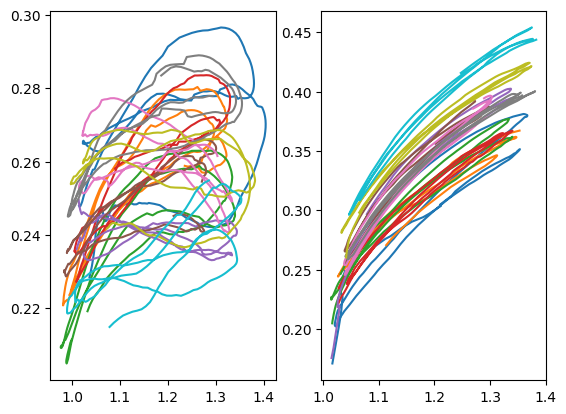

In [95]:
trajs_p1 = [data_p1_p[s[0]:s[1], :, :] for s in segments]
trajs_p2 = [data_p2_p[s[0]:s[1], :, :] for s in segments]

# downsample
stepsize = 1
cutoff = 400
offset = 150

trajs_p1_downsampled = np.array([a[::stepsize,:,:][offset:cutoff] for a in trajs_p1])
trajs_p1 = trajs_p1_downsampled.reshape(19,cutoff-offset,26*3)[:,:,-2:]

trajs_p2_downsampled = np.array([a[::stepsize,:,:][offset:cutoff] for a in trajs_p2])
trajs_p2 = trajs_p2_downsampled.reshape(19,cutoff-offset,26*3)[:,:,-2:]

dim_p1 = 2
dim_p2 = 2

plt.subplot(121)
for i in range(0,10):
    plt.plot(trajs_p1[i,:,0],trajs_p1[i,:,1])

plt.subplot(122)
for i in range(0,10):
    plt.plot(trajs_p2[i,:,0],trajs_p2[i,:,1])

In [97]:
tmp = np.copy(trajs_p1)
trajs_p1 = np.copy(trajs_p2)
trajs_p2 = tmp

In [98]:
data = hr_cycle_dataset.HRCycleDataset(trajs_p1[:5], trajs_p2[:5], dim_p1, dim_p2)

In [99]:
T_period = (2*np.pi)/data.w
params = {'batch_size': batch_size, 'shuffle': True}
dataloader = DataLoader(data, **params)

In [100]:
## optimization ##
lr = 0.001
weight_decay = 0.001

In [101]:
lsd = model.LinearLimitCycle(dim_p1, device, dt=data.dt, T_period=T_period).to(device)
flow_human = create_flow_seq(dim_p1, depth).to(device)
flow_robot = create_flow_seq(dim_p2, depth).to(device)
iflow = model.HumanRobotFlow2(dynamics=lsd, model_human=flow_human,
                             model_robot=flow_robot).to(device)

params = list(flow_human.parameters()) + list(flow_robot.parameters()) + list(lsd.parameters())
optimizer = optim.Adamax(params, lr = lr, weight_decay= weight_decay)

In [112]:
def hr_cycle_dynamics_train(iflow, x, y):
    ## Separate Data ##
    y0 = x
    y1 = y[0]
    step = y[1][0]
    phase = y[2]
    ## Evolve dynamics forward ##
    x0_h, x0_r, log_det_J_x0_h, log_det_J_x0_r = iflow(y0)
    x1_h, x1_r, log_det_J_x1_h, log_det_J_x1_r = iflow(y1)

    #x0 = torch.cat([x0_h, x0_r], dim=1)
    #x1 = torch.cat([x1_h, x1_r], dim=1)

    ### Forward Conditioning ###
    log_p_z1_h = iflow.dynamics.cartesian_cond_log_prob(x0_h, x1_h, T=step)
    log_p_z1_r = iflow.dynamics.cartesian_cond_log_prob(x0_r, x1_r, T=step)
    log_trj = log_p_z1_h + log_p_z1_r + log_det_J_x1_h.squeeze() + log_det_J_x1_r.squeeze()

    ### Stable Point ###
    log_p_z0_h = iflow.dynamics.stable_log_prob(x0_h, ref_phase=phase)
    log_p_z0_r = iflow.dynamics.stable_log_prob(x0_r, ref_phase=phase)
    log_stable = log_p_z0_h + log_p_z0_r + log_det_J_x0_h.squeeze() + log_det_J_x0_r.squeeze()

    log_total = torch.mean(log_stable) + torch.mean(log_trj)

    y = torch.from_numpy(data.train_data[0][:][None, :]).float().to(device).squeeze()
    y_h = y[:, :2]
    y_r = y[:, 2:]
    y0_h = y_h[:1]
    y0_r = y_r[:1]

    trj_h, trj_r = iflow.generate_trj(y0_h, y0_r, T=250)
    return -log_total

/var/folders/j2/x3441d157fvcr8zj_13jkc8c0000gn/T/ipykernel_5284/1558922369.py:8: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(parameters=iflow.parameters(), max_norm=10, norm_type=2.0)


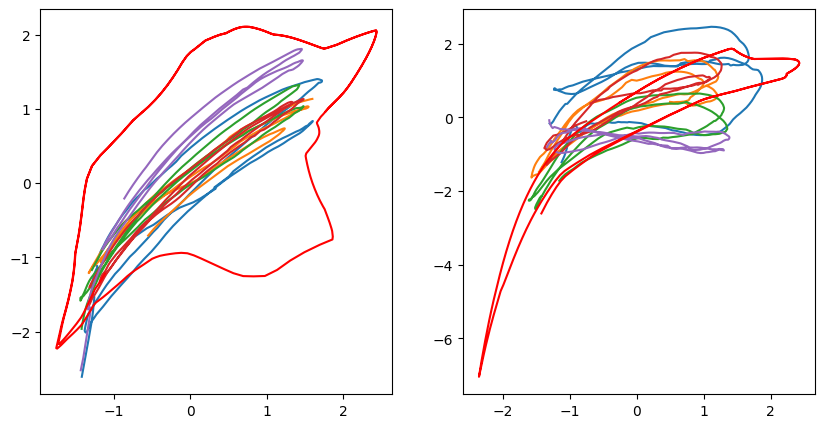

KeyboardInterrupt: 

In [113]:
for i in range(nr_epochs):
    # Training
    for local_x, local_y in dataloader:
        dataloader.dataset.set_step()
        optimizer.zero_grad()
        loss = hr_cycle_dynamics_train(iflow, local_x, local_y)
        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm(parameters=iflow.parameters(), max_norm=10, norm_type=2.0)
        optimizer.step()

    ## Validation ##
    if i%10 == 0:
        with torch.no_grad():
            iflow.eval()

            # plotting
            y0 = torch.from_numpy(data.train_data[0][0][None, :]).float().to(device)
            y0_h = y0[:, :2]
            y0_r = y0[:, 2:]

            trj_h, trj_r = iflow.generate_trj(y0_h, y0_r, T=400)
            trj_h = trj_h.detach().cpu().numpy()
            trj_r = trj_r.detach().cpu().numpy()

            plt.figure(figsize=(10,5))
            plt.subplot(121)
            for t in data.train_data[:, :, :data.dim_h]:
                plt.plot(t[:,0], t[:,1])

            plt.plot(trj_r[:,0], trj_r[:,1], 'r')

            plt.subplot(122)
            for t in data.train_data[:, :, data.dim_h:]:
                plt.plot(t[:,0], t[:,1])
            plt.plot(trj_h[:,0], trj_h[:,1], 'r')

            plt.show()

            # likelihood
            # step = 20
            # trj = data.train_data[0]
            # trj_x0 = to_torch(trj[:-step,:], device)
            # trj_x1 = to_torch(trj[step:,:], device)
            # phase = to_torch(data.train_phase_data[0][:-step], device)
            # cycle_log_likelihood(trj_x0, trj_x1, phase, step, iflow, device)

In [104]:
trj_h, trj_r = iflow.generate_trj(y0_h, y0_r, T=4000)

In [105]:
trj_r = trj_r.detach().numpy()

In [106]:
trj_r[:100]

array([[-1.1185558e+00, -1.2180295e+00],
       [-1.1493315e+00, -1.2684959e+00],
       [-1.1802790e+00, -1.3154289e+00],
       [-1.2112920e+00, -1.3590223e+00],
       [-1.2423980e+00, -1.4004616e+00],
       [-1.2733244e+00, -1.4635817e+00],
       [-1.3039726e+00, -1.5301518e+00],
       [-1.3342859e+00, -1.5937042e+00],
       [-1.3642101e+00, -1.6543159e+00],
       [-1.3937777e+00, -1.7122840e+00],
       [-1.4229004e+00, -1.7675401e+00],
       [-1.4515076e+00, -1.8143746e+00],
       [-1.4795941e+00, -1.8519477e+00],
       [-1.5071582e+00, -1.8871243e+00],
       [-1.5341849e+00, -1.9200119e+00],
       [-1.5606930e+00, -1.9507835e+00],
       [-1.5880405e+00, -1.9827068e+00],
       [-1.6169537e+00, -2.0175061e+00],
       [-1.6454904e+00, -2.0507343e+00],
       [-1.6739738e+00, -2.0832155e+00],
       [-1.7016646e+00, -2.1133471e+00],
       [-1.7276479e+00, -2.1391721e+00],
       [-1.7491465e+00, -2.1546028e+00],
       [-1.7459856e+00, -2.1142972e+00],
       [-1.73282

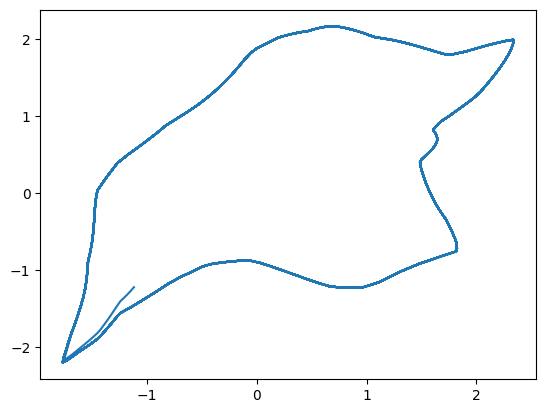

In [107]:
plt.plot(trj_r[:,0], trj_r[:,1])

In [108]:
dim_h = 2
dim_r = 2

In [109]:
y0 = torch.from_numpy(data.train_data[1][0][None, :]).float().to(device)
y0_h = y0[:, :dim_h]
y0_r = y0[:, dim_h:]

In [110]:
y = torch.from_numpy(data.train_data[1]).float().to(device)
y_h = y[:, :dim_h]
y_r = y[:, dim_h:]

In [111]:

out = iflow.generate_trj_hr(y0_h, y0_r, y_h)
out = out.detach().numpy()

RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 1

In [ ]:
plt.plot(out[:, 0], out[:, 1], 'r')
plt.plot(data.train_data[0][:,2], data.train_data[0][:,3])